# **1. Load and Explore the Dataset**

## **1.1 Load Required Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

## **1.2: Load First 5000 Rows of Dataset**

In [2]:
df = pd.read_csv('/media/nsriad/Documents/UAH/Spring 25/OS-Lawrence/Project/Code/processes_datasets.csv')
print("Shape:", df.shape)
df.head()

Shape: (404176, 29)


,JobID,SubmitTime,WaitTime,RunTime,NProcs,AverageCPUTimeUsed,Used Memory,ReqNProcs,ReqTime:,ReqMemory,...,JobStructureParams,UsedNetwork,UsedLocalDiskSpace,UsedResources,ReqPlatform,ReqNetwork,ReqLocalDiskSpace,ReqResources,VOID,ProjectID
0,1,1136070024,203761,138467,1,138371,98652,1,259200,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2,1136070690,0,11,1,4,35848,1,259200,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,3,1136071207,117,201203,1,0,0,1,259200,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,4,1136071267,4406,196985,1,0,0,1,259200,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,5,1136071269,202516,19520,1,18731,522268,1,259200,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [3]:
selected_columns = ['SubmitTime', 'UserID', 'Used Memory', 'ReqTime: ', 'ReqMemory', 'RunTime ']
df_filtered = df[selected_columns].copy()
#df_filtered = df_filtered[df_filtered['RunTime '] > 0]  # remove rows with 0 or invalid target
print("Selected features and target:", df_filtered.columns.tolist())
df_filtered.head()

Selected features and target: ['SubmitTime', 'UserID', 'Used Memory', 'ReqTime: ', 'ReqMemory', 'RunTime ']


,SubmitTime,UserID,Used Memory,ReqTime:,ReqMemory,RunTime
0,1136070024,U2004S1,98652,259200,-1,138467
1,1136070690,U1023S0,35848,259200,-1,11
2,1136071207,U2035S1,0,259200,-1,201203
3,1136071267,U2035S1,0,259200,-1,196985
4,1136071269,U2035S1,522268,259200,-1,19520


In [4]:
le = LabelEncoder()
df_filtered['UserID'] = le.fit_transform(df_filtered['UserID'])

In [22]:
df_filtered.shape

(339314, 6)

In [23]:
df_filtered.columns

Index(['SubmitTime', 'UserID', 'Used Memory', 'ReqTime: ', 'ReqMemory',
       'RunTime '],
      dtype='object')

In [5]:
# using first 5000 datatpoints
df_filtered = df_filtered.head(5000)
print("Shape:", df_filtered.shape)

Shape: (5000, 6)


In [6]:
# exclude process with no burst time i.e., -1
df_filtered = df_filtered[df_filtered['RunTime '] != -1]
print("Shape:", df_filtered.shape)

Shape: (4340, 6)


## **1.5 Split dataset**

In [7]:
# Target
y = df_filtered['RunTime ']

# Features
X = df_filtered.drop(columns=['RunTime '])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3472, 5)
y_train shape: (3472,)
X_test shape: (868, 5)
y_test shape: (868,)


## **1.6: Normalize data**

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Normalize minmax
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# **2. Train MLP Regressor on Filtered Data**

## **2.1: Define Dataset and DataLoaders**

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom dataset class
class ProcessDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets and loaders
train_ds = ProcessDataset(X_train, y_train)
test_ds = ProcessDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

## **2.2: Define the MLP Regressor in PyTorch**

In [11]:
class MLPRegressor(nn.Module):
    def __init__(self, input_size):
        super(MLPRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.model(x)

## **2.3: Training Function**

In [12]:
def train_model(model, dataloader, optimizer, criterion, device, num_epochs=50):
    model.train()
    epoch_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    return epoch_losses

## **2.4: Evaluation Metrics**

In [13]:
def evaluate_model(model, dataloader, y_true, device):
    model.eval()
    preds = []

    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            preds.append(y_pred.cpu().numpy())

    y_pred = np.vstack(preds).flatten()
    y_true = y_true.values.flatten()

    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    cc = np.corrcoef(y_true, y_pred)[0, 1]
    rae = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true - np.mean(y_true)))

    return {
        'MAE': mae,
        'R2': r2,
        'CC': cc,
        'RAE (%)': rae * 100
    }

## **2.5: Train MLP Model**

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# number of epochs
num_epochs = 5000

# initialize model and optimizer
model = MLPRegressor(input_size=X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Train and collect loss per epoch
loss_history = train_model(model, train_loader, optimizer, criterion, device, num_epochs=num_epochs)
torch.save(model.state_dict(), 'non_hist_mlp_burst_predictor.pth')

Using device: cpu
Epoch 100/5000, Loss: 1046972552.1455
Epoch 200/5000, Loss: 846720858.1818
Epoch 300/5000, Loss: 369327758.2545
Epoch 400/5000, Loss: 300109986.4727
Epoch 500/5000, Loss: 251701564.6909
Epoch 600/5000, Loss: 229431112.4000
Epoch 700/5000, Loss: 227686204.0909
Epoch 800/5000, Loss: 236792368.3091
Epoch 900/5000, Loss: 229973669.9545
Epoch 1000/5000, Loss: 219910968.5182
Epoch 1100/5000, Loss: 219938261.2182
Epoch 1200/5000, Loss: 214217391.4364
Epoch 1300/5000, Loss: 210596705.5636
Epoch 1400/5000, Loss: 198983282.3182
Epoch 1500/5000, Loss: 180525637.8727
Epoch 1600/5000, Loss: 161198227.5636
Epoch 1700/5000, Loss: 153121694.5545
Epoch 1800/5000, Loss: 150755564.1818
Epoch 1900/5000, Loss: 147906416.7909
Epoch 2000/5000, Loss: 145903425.4091
Epoch 2100/5000, Loss: 144126759.0273
Epoch 2200/5000, Loss: 142593483.2273
Epoch 2300/5000, Loss: 138841797.7182
Epoch 2400/5000, Loss: 136739315.7818
Epoch 2500/5000, Loss: 130125457.9864
Epoch 2600/5000, Loss: 139268057.2455
Ep

In [15]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

def loss_plot(num_epochs, loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), loss_history)
    plt.title("Training Loss Curve (MLP)")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.show()

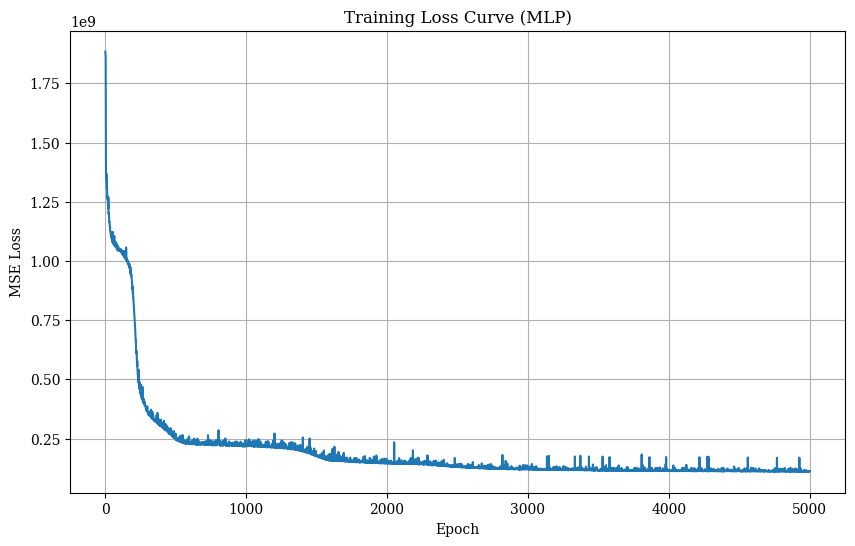

In [18]:
loss_plot(num_epochs, loss_history)

# **3. Model Evaluation and Prediction**

## **3.1: Evaluation metrics**

In [29]:
# y_test must be a numpy array or torch tensor (already flattened)
results = evaluate_model(model, test_loader, y_test, device)

# Print results
print("Evaluation Metrics for MLP:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

Evaluation Metrics for MLP:
MAE: 3853.6431
R2: 0.8136
CC: 0.9037
RAE (%): 13.8571


## **3.2: Prediction**

In [20]:
model.eval()
predictions = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        predictions.append(y_pred.cpu().numpy())

# Flatten into one array
y_pred = np.vstack(predictions).flatten()

In [21]:
# Convert true y values to a flat array if not already
y_true = y_test.values.flatten()

In [28]:
# Show a few examples
import pandas as pd
start = 100
end = 150
comparison_df = pd.DataFrame({
    "Actual (RunTime)": y_true[start:end],
    "Predicted (RunTime)": y_pred[start:end]
})

# Round for cleaner display
comparison_df = comparison_df.round(2)

# Display as table
comparison_df

,Actual (RunTime),Predicted (RunTime)
0,94444,97144.070312
1,42802,41611.519531
2,96832,98091.609375
3,113,0.000000
4,28,0.000000
5,1722,1118.000000
6,12123,0.000000
7,66,0.000000
8,17,0.000000
9,94609,96566.703125


In [23]:
def plot_mlp_predictions(model, dataloader, y_test_raw, device, title="MLP"):
    model.eval()
    preds = []

    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            preds.append(y_pred.cpu().numpy())

    y_pred = np.vstack(preds).flatten()
    y_true = y_test_raw.values.flatten()

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
             'r--', label='Perfect Prediction')
    plt.xlabel("Actual RunTime")
    plt.ylabel("Predicted RunTime")
    plt.title(f"{title} - Actual vs Predicted")
    plt.legend()
    plt.grid(True)
    plt.show()


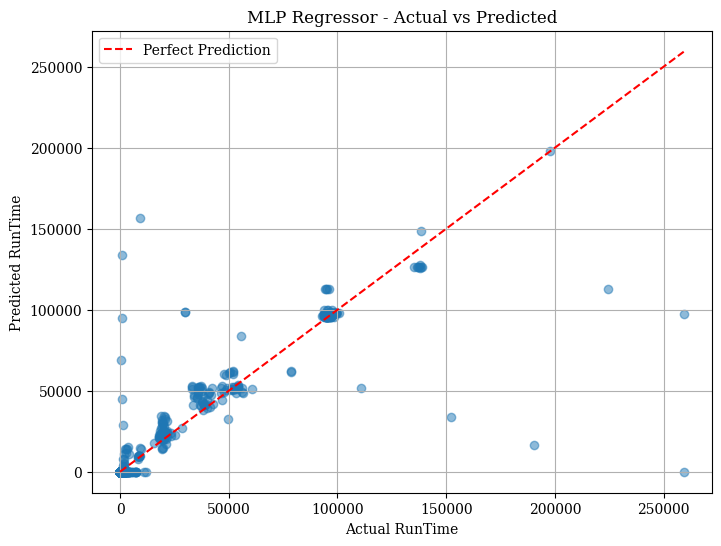

In [24]:
plot_mlp_predictions(model, test_loader, y_test, device, title="MLP Regressor")